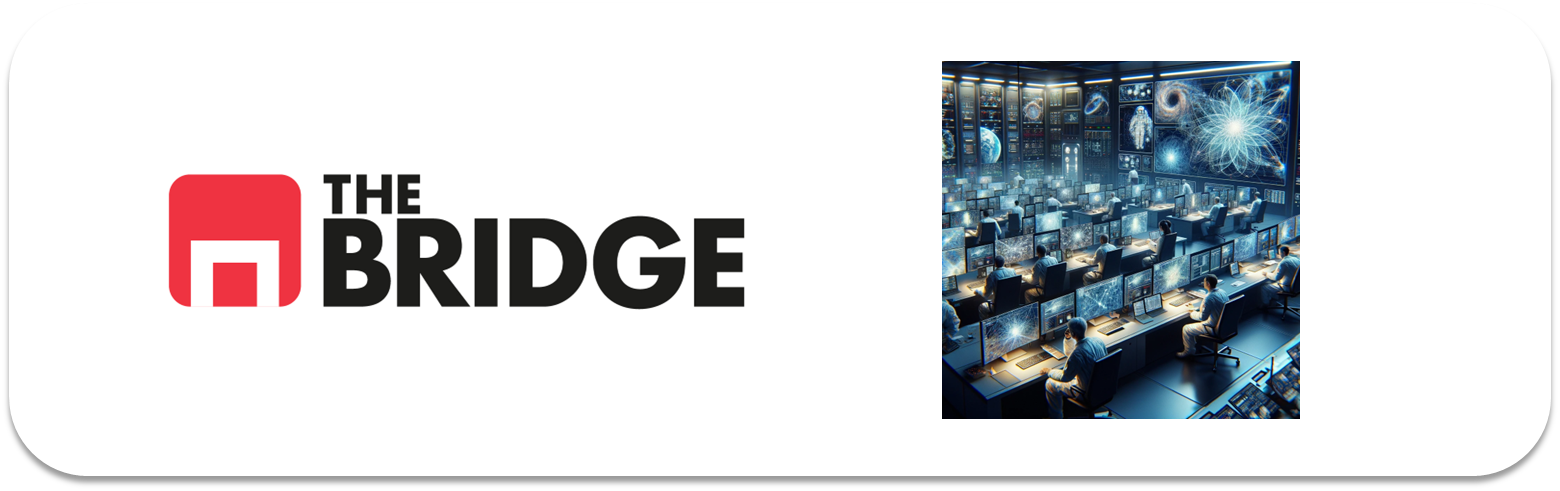

*RECUERDA QUE ESTE NOTEBOOK ES PARA QUE LO EJECUTES EN TU ORDENADOR, NO EN LA PLATAFORMA*


## Transfer Learning y Fine Tuning

Como hemos visto en la teoria, una de las capacidades más potentes de los modelos DL es que podemos apoyarnos en modelos preentrenados (o preconstruidos si solo queremos su topología). En las siguientes sesiones vamos a emplear dos modelos de este tipo de redes convolucionales especializadas en la clasifiación de imagénes para mostrar los conceptos de transfer y fine tuning.

### Principales arquitecturas convolucionales

Al finalizar la unidad anterior vimos cuatro arquitecturas de referencia de las cuales hoy en día hay buenas evoluciones:

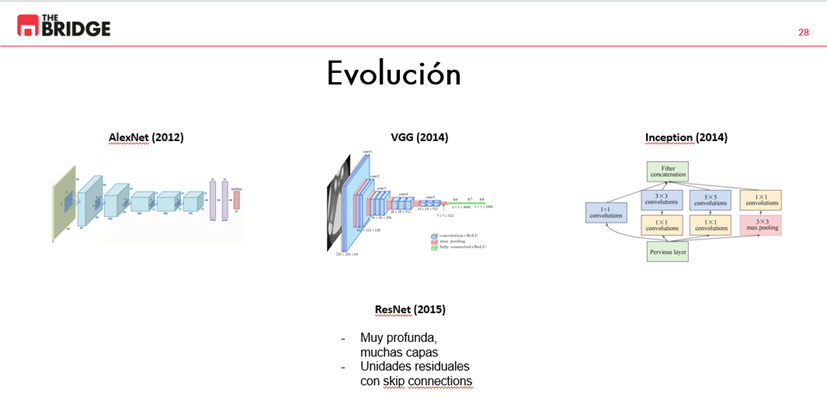

Y hoy en día son arquitecturas basadas en las anteriores la más utilizadas en la comunidad:
* VGG-16
* VGG-19
* Inception V3
* XCeption
* ResNet-50

Para más detalle sobre el funcionamiento de cada red, consultar el [Hands on Machine Learning for Python](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch14.html#cnn_chapter).

NOTA: Un detalle es que estas redes las puedes bajar sólo su topología o con los pesos preentrenados.


### Primera carga y Zero-Shot Learning

La primera arquitectura que vamos a ver corresponde a la **ResNet50V2**. Además lo primero que vamos a intentar con ella es un zero-shot learning que básicamente consiste en bajar la red preentrenada coger nuestros datos, adaptarlos a las dimensiones de entrada de la ResNet y hacer predicciones directamente.

<img src="./img/ResNet50.png" alt="drawing" width="600"/>

Lo primero es hacer nuestros "imports", fijate que además de los habituales importamos skimage y cv2 para poder ver y tratar las imágenes:

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf



from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models




Y ahora nos descargamos "el modelo" (realmente es un clase que cargará el modelo al inicializarse):

In [2]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

In [3]:

'''
imagenet es un corpus de imagenes con el que se ha clasificado el ResNet50V2
http://www.image-net.org/

Cargamos toda la red ya entrenada, y la usaremos para predecir
include_top=True --> Para que incluya la fully connected layer.
include_top=False --> Desarrollamos la fully connected layer
ojo el input shape que sea el de las imagenes que introduciremos. Esta limitado a imagenes de tamaño 224x224
classifier_activation se usa si include_top=True
'''

base_model = ResNet50V2(input_shape=(224, 224,3),
                        include_top=True, # Como vamos a emplearla directamente, incluimos también la parte de capas densas que hacen la predicción en este caso clasificación de imagenes 
                        weights="imagenet", # Se carga con los pesos entrenados para el dataset de imagenet
                        classifier_activation="softmax")

In [4]:
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,613,800 (97.71 MB)

 Trainable params: 25,568,360 (97.54 MB)

 Non-trainable params: 45,440 (177.50 KB)

Cargamos algunas imagenes desde local, para ver qué tal funciona la red ResNet50V2 ya entrenada.

In [5]:
import os

tipos = []

def read_data(path):
    X = []

    for file in [file for file in os.listdir(path) if file.endswith(".jpg") or file.endswith(".jpeg")]:
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (224, 224))
        print(path + '/' + file)
        tipos.append(file)
        
        X.append(smallimage)

    return np.array(X)
    

x_figs = read_data('img')

# Procesar las imagenes tal y como entran en el modelo
x_test = preprocess_input(x_figs)
print(x_test.shape)

img/bear-1.jpg
img/bond.jpg
img/cat.8016.jpg
img/cat.8037.jpg
img/dog.11856.jpg
img/dog.11857.jpg
img/horse.jpg
img/karate.jpg
img/novia.jpeg
img/pizza.jpg
(10, 224, 224, 3)


In [6]:
def plot_image(i, class_predicted, class_prob, true_label, img):
  img = img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  plt.xlabel(f"{class_predicted} {class_prob:.2f} ({true_label})")

def plot_value_array(predictions_array, predictions_labels):
  #predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(len(predictions_labels)),labels = predictions_labels)
  plt.yticks([])
  thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  plt.xlabel("top-5 predicciones")

  #thisplot[predicted_label].set_color('red')
  #thisplot[true_label].set_color('blue')

Ahora predecimos sobre las imagenes nuestras, como puedes ver, sin tocar nada más en el modelo

In [7]:
num_rows = len(x_test)
num_cols = 1
num_images = num_rows * num_cols

#plt.figure(figsize=(40, 40))

preds = base_model.predict(x_test)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Y mostramos cada imagen y el nivel de confianza en las etiquetas top que puede dar ResNet

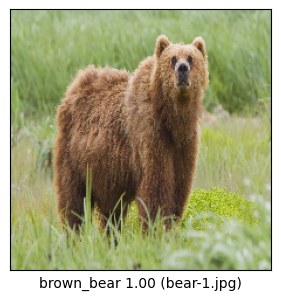

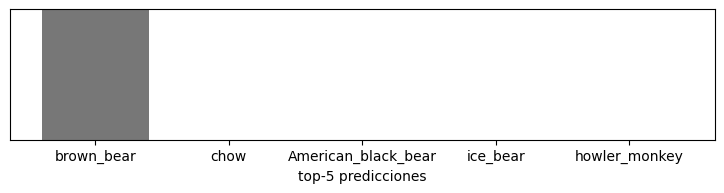

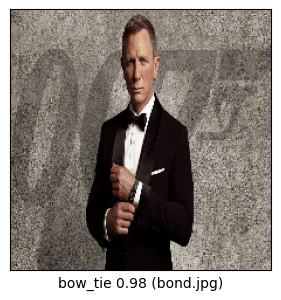

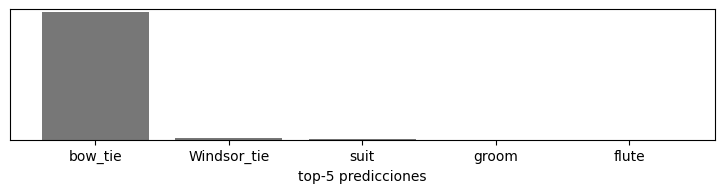

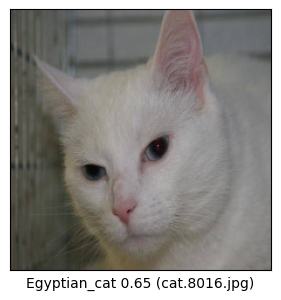

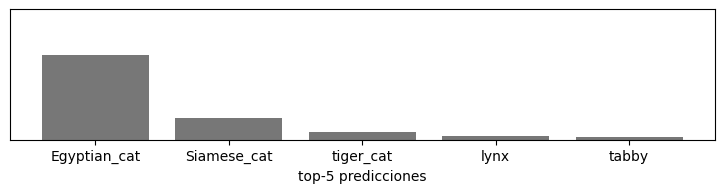

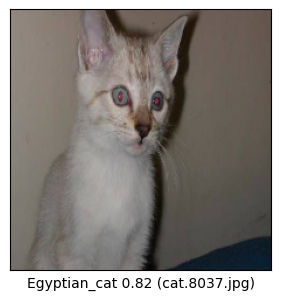

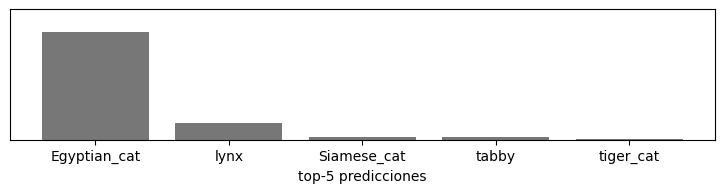

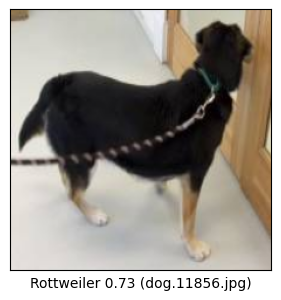

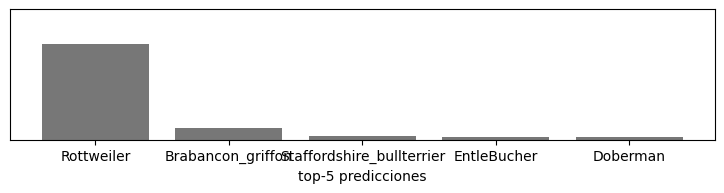

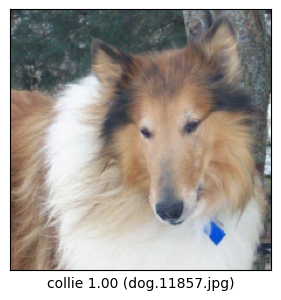

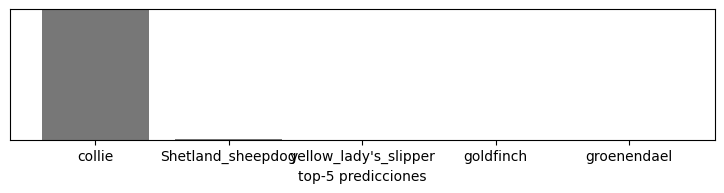

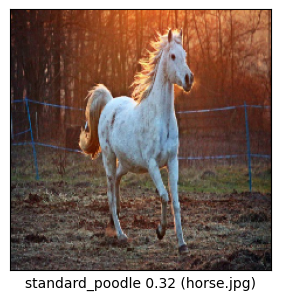

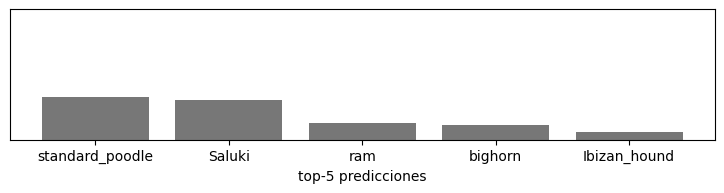

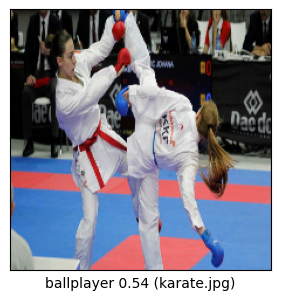

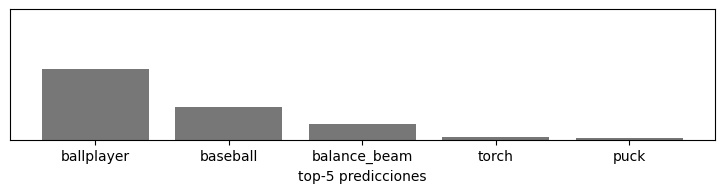

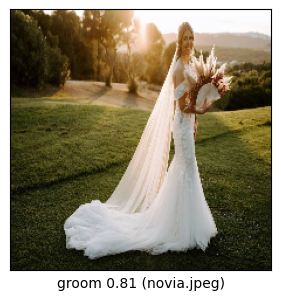

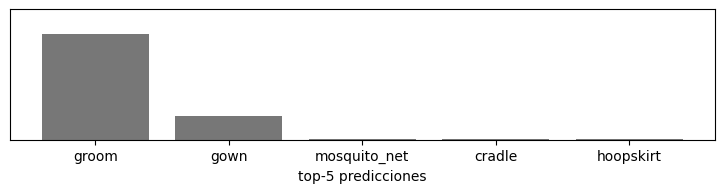

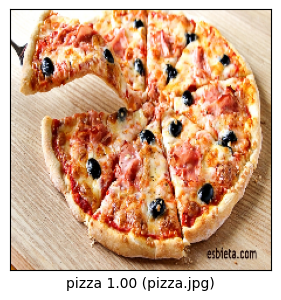

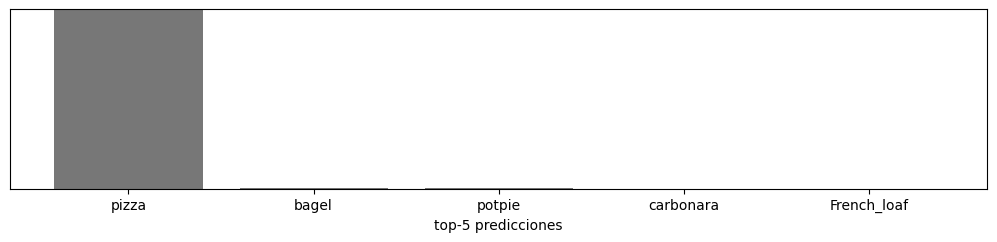

In [8]:
# decode the results into a list of tuples (class, description, probability)
decodes = decode_predictions(preds, top=5)

for i,j in enumerate(decodes):
    prediction_proba = []
    predicted_classes = []
    for decode in j:
        prediction_proba.append(decode[2])
        predicted_classes.append(decode[1])
    plt.figure(figsize=(40, 40))
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i,predicted_classes[0],prediction_proba[0],tipos[i],x_figs)
    plt.figure(figsize=(20, 20))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(prediction_proba, predicted_classes)
plt.tight_layout()
plt.show()

En algunos casos los resultados son muy buenos en otros son "raros", por ejemplo la "Pajarita" de James Bond. No siempre podremos hacer un zero-shot de hecho eso está siendo ahora con los LLMs con los que realmente está funcionando.

***

### Transfer Learning

Si recuerdas en el transfer a diferencia del shot, vamos a mantener el modelo quitándole su "cabeza" densa y colocando una que entrenaremos con nuestros datos. Pues vamos a ello.

NOTA: No todos los modelos tienen la misma forma de hacer el transfer o el fine tuning que vamos a enseñar aquí, la filosofía es la misma pero los pasos pueden diferir por implementación, datos, etc. Cuando quieras recurrir a este sistema deberás leer las instrucciones que acompañen al modelo escogido en el repositorio del que te lo vayas a descargar. 

Para este caso vamos a emplear el modelo basado en la arquitectura **VGG**:

<img src="./img/vgg16.png" alt="drawing" width="150"/>

Y los datos de imagenes de perros y gatos de la práctica obligatoria pasada, así que cambia el path de la celda siguiente para que apunte al lugar donde tengas las imagenes de train de esa práctica

In [9]:


IM_SIZE=64

TRAIN_PATH = './data/github_train/'
filenames = os.listdir(TRAIN_PATH)
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)
    
df = pd.DataFrame({
    'filenames': filenames,
    'category': categories
})

train_df, validate_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

Para poder mejorar la generalización del modelo vamos a emplear aumentado de imágenes:

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40, # Rotacion en grados
                                   width_shift_range = 0.2, # Desplazamiento a lo ancho
                                   height_shift_range = 0.2,
                                   shear_range = 0.2, # Intensidad del angulo de rotacion
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale = 1.0/255. )

Una de las ventajas de los generadores de imágenes sintéticas de tensorflow es que pueden leer imágenes a partir de fichero en vez de tener que pasarles directamente los arrays de cada una de ellas.

In [11]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    TRAIN_PATH, # Donde busscar todo esto
                                                    x_col='filenames', # Nombres de archivos
                                                    y_col='category', # Target
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (IM_SIZE, IM_SIZE))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              TRAIN_PATH,
                                                              x_col='filenames',
                                                              y_col='category',
                                                              batch_size = 20,
                                                              class_mode = 'binary',
                                                              target_size = (IM_SIZE, IM_SIZE))

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


Cargamos el modelo como hicimos antes con ResNet

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (IM_SIZE, IM_SIZE, 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')


Fijate en el argumento include_top, está puesto ahora a False para poder quitar la cabecera densa de la VGG. Ahora tenemos que añadirle la red densa que queramos entrenar nosotros, en este caso va a ser muy sencilla. Y para poder añadirla sobre el resto de la arquitectura de la VGG, recurrimos a la interfaz funcional que vimos el sprint anterior

Observa también que vamos a "congelar" las capas de la VGG, es decir no vamos a permitir que se entrenen haciendo lo siguiente:

In [13]:
for layer in base_model.layers:
    layer.trainable = False
    


In [14]:
# Y ahora ya sí nuestra modelo "tuneado":

In [15]:
##### FULLY CONNECTED LAYER #####
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,289 (60.14 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Y ya ahora solo tenemos que entrenar:

In [17]:
vgghist = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100, # Cantidad de batches en los que divide el epoch
                    epochs = 10)

Epoch 1/10


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - acc: 0.5826 - loss: 0.7944 - val_acc: 0.6625 - val_loss: 0.6050
Epoch 2/10
 60/100 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - acc: 0.7035 - loss: 0.5678

c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - acc: 0.7071 - loss: 0.5625 - val_acc: 0.7350 - val_loss: 0.5083
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - acc: 0.7414 - loss: 0.5221 - val_acc: 0.7475 - val_loss: 0.5034
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - acc: 0.7344 - loss: 0.5285 - val_acc: 0.7312 - val_loss: 0.5174
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - acc: 0.7408 - loss: 0.5137 - val_acc: 0.7600 - val_loss: 0.4760
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - acc: 0.7243 - loss: 0.5274 - val_acc: 0.7387 - val_loss: 0.4969
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - acc: 0.7322 - loss: 0.5498 - val_acc: 0.7487 - val_loss: 0.4983
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - acc: 0.7421 - loss: 0.5098 - val_acc: 0.7588 - val_loss: 0.4744
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - acc: 0.7259 - loss: 0.5243 - val_acc: 0.7600 - val_loss: 0.4713
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/

Y tendríamos nuestro modelo sobre la VGG, vamos a evaluarlo (ahora si que vamos a convertir las imagenes a arrays de numpy):

In [18]:
TEST_PATH = "./data/github_test/"

def read_data(path, im_size):
    X = []
    Y = []

    for file in os.listdir(path):
        image = imread(path + '/' + file)
        smallimage = cv2.resize(image, (im_size,im_size))
        
        X.append(smallimage/255.)
        
        category = file.split('.')[0]
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IM_SIZE)
X_test, y_test = read_data(TEST_PATH, IM_SIZE)

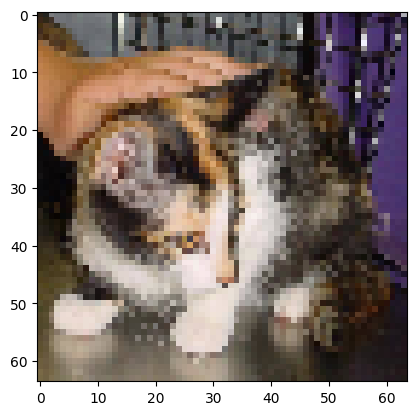

In [19]:
plt.imshow(X_train[12])

In [20]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - acc: 0.8168 - loss: 0.4095
test loss, test acc: [0.44731444120407104, 0.7879999876022339]


Bueno, no esta mal, pero igual podríamos hacer más... Veamos una segunda posibilidad dentro del transfer learning que ya roza bastante o se solapa con el fintuning

***

### Transfer Learning con entrenamiento de capas superiores

Veamos las capas de nuestro modelo (version del VGG):

In [21]:
for indice, layer in enumerate(model.layers):
    print("Capa %d: %s" %(indice, layer.name))

Capa 0: input_layer_1
Capa 1: block1_conv1
Capa 2: block1_conv2
Capa 3: block1_pool
Capa 4: block2_conv1
Capa 5: block2_conv2
Capa 6: block2_pool
Capa 7: block3_conv1
Capa 8: block3_conv2
Capa 9: block3_conv3
Capa 10: block3_pool
Capa 11: block4_conv1
Capa 12: block4_conv2
Capa 13: block4_conv3
Capa 14: block4_pool
Capa 15: block5_conv1
Capa 16: block5_conv2
Capa 17: block5_conv3
Capa 18: block5_pool
Capa 19: flatten
Capa 20: dense
Capa 21: dropout
Capa 22: dense_1


En este caso vamos a reentrenar las últimas capas, las que corresponden al quinto bloque de la arqitectura

In [22]:
for layer in model.layers[15:19]:
    print(layer.name)
    layer.trainable = True

block5_conv1
block5_conv2
block5_conv3
block5_pool


In [23]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.03),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Como los datos están sin barajar de partida:

In [24]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)


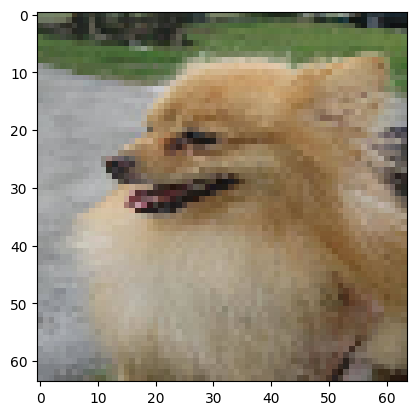

In [25]:
plt.imshow(X_train[56])

In [26]:
model.fit(X_train,y_train,
        validation_split= 0.2,
        batch_size = 32,
        #steps_per_epoch = 10, # Cantidad de batches en los que divide el epoch
        epochs = 10)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - accuracy: 0.5164 - loss: 46448.2812 - val_accuracy: 0.5175 - val_loss: 0.6926
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.4985 - loss: 0.6936 - val_accuracy: 0.5175 - val_loss: 0.6925
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.5164 - loss: 0.6929 - val_accuracy: 0.4825 - val_loss: 0.6993
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.5069 - loss: 0.6948 - val_accuracy: 0.5175 - val_loss: 0.6928
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.4915 - loss: 0.6931 - val_accuracy: 0.5175 - val_loss: 0.6930
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.5099 - loss: 0.6928 - val_accuracy: 0.5175 - val_loss: 0.6931
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.4915 - loss: 0.6925 - val_accuracy: 0.4825 - val_loss: 0.6940
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.4830 - los

In [27]:
model.evaluate(X_test,y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.8206 - loss: 0.6688


[0.6939154267311096, 0.5]

Aquí termina la parte del transfer, en la siguiente sesión vamos a ver lo que sería un fine-tuning de las ResNet
***

### Fine-tuning: ResNet50V2 

Cargamos el modelo pero ajustándolo a imagenes de 32x32 y observa que no cargamos pesos en la red, solo la topología. Y tampoco nos quedamos con las cabezas superiores.

In [28]:
IM_SIZE=32

base_model = ResNet50V2(input_shape=(IM_SIZE, IM_SIZE,3),
                        include_top=False, # Importante!!
                        weights = None, # Importante!!
                        classifier_activation="softmax")

In [29]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])



Volvemos a hacer uso del aumentado del dataset mediante la manipulación de las imagenes originales

In [30]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    TRAIN_PATH,
                                                    x_col='filenames',
                                                    y_col='category',
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (IM_SIZE, IM_SIZE))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              TRAIN_PATH,
                                                              x_col='filenames',
                                                              y_col='category',
                                                              batch_size = 20,
                                                              class_mode = 'binary',
                                                              target_size = (IM_SIZE, IM_SIZE))

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [31]:
history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10) # PAra reducir los tiempos de entrenamiento solo haremos epocas de 100 batches, de 20 datos o sea entrenamos con 2000 imagenes por época

Epoch 1/10


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - acc: 0.5313 - loss: 0.8224 - val_acc: 0.4750 - val_loss: 0.6957
Epoch 2/10
 60/100 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - acc: 0.5267 - loss: 0.7783

c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - acc: 0.5303 - loss: 0.7766 - val_acc: 0.4725 - val_loss: 0.7236
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - acc: 0.5148 - loss: 0.7776 - val_acc: 0.5175 - val_loss: 0.6928
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - acc: 0.5037 - loss: 0.7580 - val_acc: 0.5450 - val_loss: 0.6887
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - acc: 0.5292 - loss: 0.7318 - val_acc: 0.5612 - val_loss: 0.6825
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - acc: 0.5404 - loss: 0.7250 - val_acc: 0.5300 - val_loss: 0.6990
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - acc: 0.5413 - loss: 0.7321 - val_acc: 0.5587 - val_loss: 0.7049
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - acc: 0.5195 - loss: 0.7242 - val_acc: 0.5475 - val_loss: 0.6945
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - acc: 0.5440 - loss: 0.7144 - val_acc: 0.5063 - val_loss: 1.2761
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/st

Y ya estaría. Evidentemente, debes optar cambiar los hiperparámetros y ajustarlo lo más posible a tu problema y a correr.

In [ ]:
model.evaluate(X_test, y_test)

ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 64, 64, 3)

: 

### Repositorios de modelos

Aquí te dejo unas cuantas direcciones a repositorios de modelos:

[Tensorflow Hub](https://www.tensorflow.org/hub?hl=es-419)

[Aplicaciones de Keras](https://keras.io/api/applications/)

[Pytorch Hub](https://pytorch.org/hub/)

[Huggin Face's Transformers](https://huggingface.co/docs/transformers/index)